# 1. Importação de bibliotecas

In [20]:
# Imports e Configurações Iniciais
import boto3
import re
import io
from PIL import Image
import matplotlib.pyplot as plt
import unicodedata


In [21]:
# Inicializar os clientes da AWS
textract = boto3.client('textract', region_name='us-east-1')  # ou sua região
rekognition = boto3.client('rekognition', region_name='us-east-1')

In [22]:
# Função para exibir imagens
def mostrar_imagem(imagem, titulo=""):
    plt.imshow(imagem)
    plt.axis('off')
    plt.title(titulo)
    plt.show()

# 2. Extração dados CNH

## 2.1 Leitura da CNH

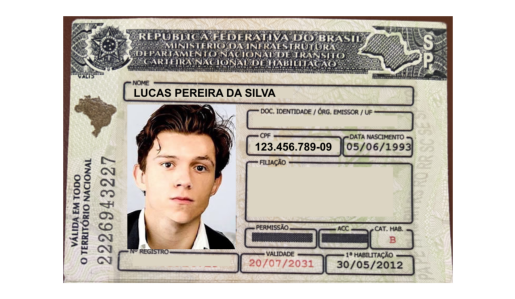

In [23]:
# Carregar Imagem da CNH
with open("../data/raw/cnh1.png", "rb") as image_file:
    imagem_cnh_bytes = image_file.read()

imagem_pil = Image.open(io.BytesIO(imagem_cnh_bytes))
mostrar_imagem(imagem_pil)

## 2.2 Extração de dados de texto

In [24]:
# Extração de Texto com Textract
resposta = textract.detect_document_text(
    Document={'Bytes': imagem_cnh_bytes}
)

# Visualizar texto detectado
for item in resposta['Blocks']:
    if item['BlockType'] == 'LINE':
        print(item['Text'])

REPUBLICA FEDERATIVA DO BRASIL
MINISTERIO DA INFRAESTRUTURA
DE PARJAMEN TO NACIONAL DE TRANSITO
CARTEIRA NACIONAL DE HABILITACAO
VALIS
NOME
LUCAS PEREIRA DA SILVA
DOC. IDENTIDADE / ORG. EMISSOR / UF
CPF
DATA NASCIMENTO
123.456.789-09
05/06/1993
FILIAÇÃO
OVNAN
Values
PERMISSÃO
ACC
CAT. HAB.
B
No REGISTRO
VALIDADE
1a HABILITAÇÃO
20/07/2031
30/05/2012


In [25]:
# Extrair Nome e CPF com Regex
texto_totoal_cnh = " ".join([
    item['Text'] for item in resposta['Blocks'] if item['BlockType'] == 'LINE'
])

# Regex simples para CPF
cpf_match = re.search(r"\d{3}\.?\d{3}\.?\d{3}-?\d{2}", texto_totoal_cnh)
nome_match = re.search(r"NOME[\s:]*([A-Z\s]+)DOC", texto_totoal_cnh)

cpf_cnh = cpf_match.group() if cpf_match else "Não encontrado"
nome_cnh = nome_match.group(1).strip() if nome_match else "Não encontrado"

print(f"CPF extraído: {cpf_cnh}")
print(f"Nome extraído: {nome_cnh}")

CPF extraído: 123.456.789-09
Nome extraído: LUCAS PEREIRA DA SILVA


## 2.3 Extração da face

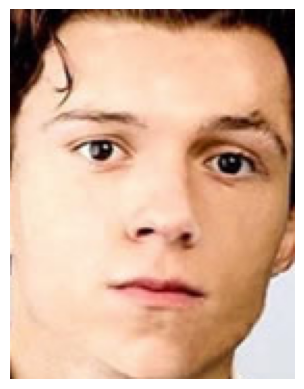

In [26]:
# Detecção de Face com Rekognition
resposta_faces = rekognition.detect_faces(
    Image={'Bytes': imagem_cnh_bytes},
    Attributes=['DEFAULT']
)

# Coordenadas da bounding box (proporcional à imagem)
bounding_box = resposta_faces['FaceDetails'][0]['BoundingBox']
img_width, img_height = imagem_pil.size

left = int(bounding_box['Left'] * img_width)
top = int(bounding_box['Top'] * img_height)
width = int(bounding_box['Width'] * img_width)
height = int(bounding_box['Height'] * img_height)

# Recortar a face
face_crop = imagem_pil.crop((left, top, left + width, top + height))
mostrar_imagem(face_crop)

# Salvar face extraída (opcional)
face_crop_rgb = face_crop.convert("RGB")
face_crop_rgb.save("../data/processed/face_cnh.jpg")


# 3. Comparação de Faces (CNH vs Selfie)

## 3.1 Carrega a Face da CNH

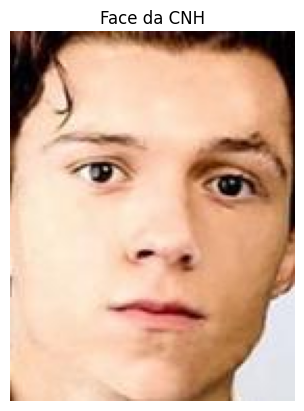

In [27]:
# Carregando imagem da face extraída
with open("../data/processed/face_cnh.jpg", "rb") as image_file:
    face_cnh_bytes = image_file.read()

# Mostrar CNH
imagem_cnh = Image.open(io.BytesIO(face_cnh_bytes))
mostrar_imagem(imagem_cnh, "Face da CNH")


## 3.2 Carrega Selfie

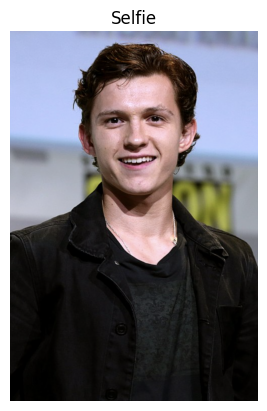

In [28]:
# 3. Carregar Imagem da Selfie
with open("../data/raw/selfie1.png", "rb") as image_file:
    selfie_bytes = image_file.read()

# Mostrar selfie
imagem_selfie = Image.open(io.BytesIO(selfie_bytes))
mostrar_imagem(imagem_selfie, "Selfie")

## 3.3 Comparando fotos

In [29]:
# 4. Comparação das Faces com Rekognition
resposta_comparacao = rekognition.compare_faces(
    SourceImage={'Bytes': face_cnh_bytes},
    TargetImage={'Bytes': selfie_bytes},
    SimilarityThreshold=80  # Limiar mínimo
)

# Verificar resultado
for face_match in resposta_comparacao['FaceMatches']:
    similaridade = face_match['Similarity']
    print(f"Similaridade: {similaridade:.2f}%")

# Interpretar resultado
if resposta_comparacao['FaceMatches']:
    if similaridade >= 90:
        print("✅ Faces compatíveis - identidade confirmada.")
    else:
        print("⚠️ Faces similares, mas abaixo do limiar de 90%.")
else:
    print("❌ Nenhuma correspondência encontrada.")


Similaridade: 99.73%
✅ Faces compatíveis - identidade confirmada.


# 4. Comparação entre Dados (CNH e Comprovante de Residência)

## 4.1 Extrai dados do comprovante Claro

In [30]:
# Funções  para extração de nome e CPF
def extrair_nome_e_cpf(texto):
    cpf_match = re.search(r'\b\d{3}\.?\d{3}\.?\d{3}-?\d{2}\b', texto)
    nome_match = re.search(r'^(.+?)\s+Código Vencimento', texto, flags=re.DOTALL)

    cpf = cpf_match.group(0) if cpf_match else None
    nome = nome_match.group(1).strip() if nome_match else None
    return nome, cpf

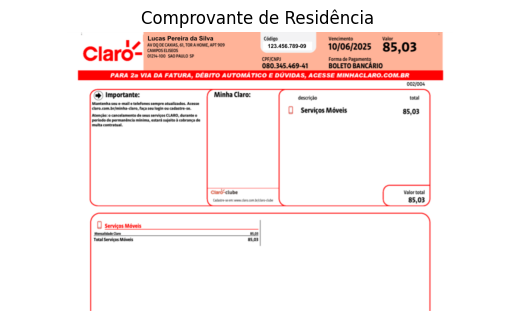

In [31]:
# 2. Carregar Imagem do Comprovante
with open("../data/raw/comprovante1.png", "rb") as image_file:
    imagem_comprovante_bytes = image_file.read()

imagem_pil = Image.open(io.BytesIO(imagem_comprovante_bytes))
mostrar_imagem(imagem_pil, "Comprovante de Residência")

In [32]:
# 3. Aplicar OCR com Textract
resposta_ocr = textract.detect_document_text(
    Document={'Bytes': imagem_comprovante_bytes}
)

# Concatenar todos os blocos de texto detectados
texto_extraido = ' '.join([
    bloco['Text'] for bloco in resposta_ocr['Blocks']
    if bloco['BlockType'] == 'LINE'
])

print("Texto detectado (resumo):")
print(texto_extraido[:1000])

Texto detectado (resumo):
Lucas Pereira da Silva Código Vencimento Valor AVDQ DE CAXIAS 61, TOR A HOME. APT909 123.456.789-09 Claro- CAMPOS ELISEOS 10/06/2025 85,03 01214-100 SAOPAULO SP CPF/CNPJ Forma de Pagamento 080.345.469-41 BOLETO BANCÁRIO PARA 2a VIA DA FATURA, DÉBITO AUTOMÁTICO E DÚVIDAS, ACESSE MINHACLARO.COM.BR 002/004 Importante: Minha Claro: descrição total Mantenha sew . mail . telefones sempre atualizados Acesse clare .com .br/minha clare. faca sew login ou cadastre-se. Serviços Móveis 85,03 Atenção: . cancelamento de seus serviços CLARO durante . periodo de permanência minima estará sujeito à cobrança de multa contratual Claro-clube Valor total Cadestre - - class com dute 85,03 Serviços Móveis Mensalidade Clare 85.03 Total Serviços Móveis 85.03


In [33]:
# 4. Extrair Nome e CPF do comprovante
nome_comprovante, cpf_comprovante = extrair_nome_e_cpf(texto_extraido)
print(f"Nome extraído do comprovante: {nome_comprovante}")
print(f"CPF extraído do comprovante: {cpf_comprovante}")

Nome extraído do comprovante: Lucas Pereira da Silva
CPF extraído do comprovante: 123.456.789-09


## Compara dados

In [34]:
import unicodedata

def normalizar(texto):
    if texto:
        texto = texto.upper().strip()
        texto = unicodedata.normalize('NFKD', texto)
        texto = ''.join(c for c in texto if not unicodedata.combining(c))
        return texto
    return None

nome_comprovante_norm = normalizar(nome_comprovante)
nome_cnh_norm = normalizar(nome_cnh)

cpf_comprovante_norm = re.sub(r'\D', '', cpf_comprovante or "")
cpf_cnh_norm = re.sub(r'\D', '', cpf_cnh or "")

# Comparação
print("---- Comparação ----")
print(f"Nomes iguais? {nome_comprovante_norm == nome_cnh_norm}")
print(f"CPFs iguais? {cpf_comprovante_norm == cpf_cnh_norm}")

---- Comparação ----
Nomes iguais? True
CPFs iguais? True
